<a href="https://colab.research.google.com/github/WarwickAI/wai203-fin-nlp/blob/main/WAI203_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
    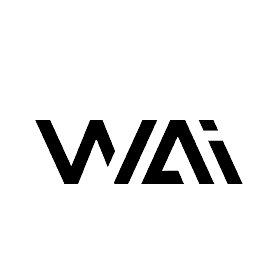
</p>

## Dependencies

In [ ]:
!pip install transformers datasets numpy sklearn wandb seaborn
!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

## 📊 Dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset(
    path='financial_phrasebank',
    name='sentences_50agree',
    split='train'
)

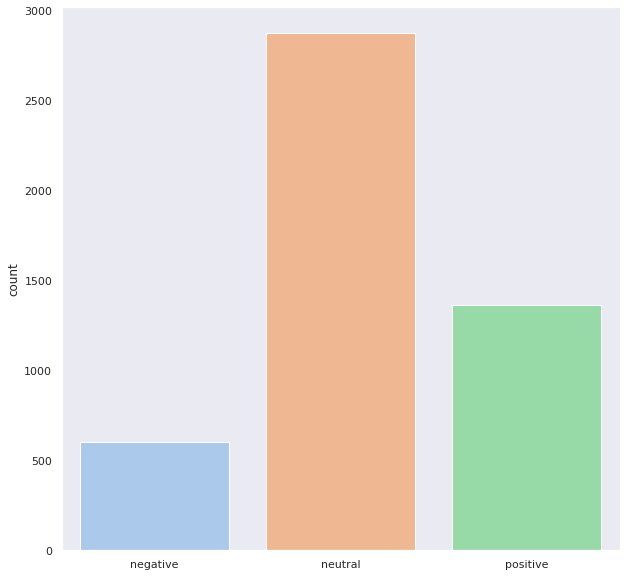

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('dark')

plt.figure(figsize=(10, 10))
sns.countplot(data=dataset.to_dict(), x='label', palette='pastel')

plt.xticks(range(3), labels)
plt.show()

## ⚙️ Preprocessing

In [ ]:
from math import ceil, floor
from transformers import PerceiverTokenizer, PerceiverForSequenceClassification, \
    Trainer, TrainingArguments, DataCollatorWithPadding

tokenizer = PerceiverTokenizer.from_pretrained('deepmind/language-perceiver')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='max_length')

labels = dataset.features['label'].names
id2label = { id: label for id, label in enumerate(labels) }
label2id = { label: id for id, label in enumerate(labels) }

tokenized_dataset = dataset.map(
    lambda examples: tokenizer(
        examples['sentence'],
        truncation=True
    ),
    batched=True
)

tokenized_splits = tokenized_dataset.train_test_split(
    train_size=0.90,
    test_size=0.10,
    shuffle=True
)

## Metrics
Calculate F1, recall, accuracy and precision so that we can evaluate our model's performance.

In [ ]:
def compute_metrics(eval_pred):
    recall_metric = load_metric('recall')
    f1_metric = load_metric('f1')
    accuracy_metric = load_metric('accuracy')
    precision_metric = load_metric('precision')

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    recall = recall_metric.compute(
            predictions=predictions,
            references=labels,
            average='macro'
    )['recall']

    f1 = f1_metric.compute(
            predictions=predictions,
            references=labels,
            average='macro'
    )['f1']

    accuracy = accuracy_metric.compute(
            predictions=predictions,
            references=labels
    )['accuracy']

    precision = precision_metric.compute(
            predictions=predictions,
            references=labels,
            average='macro'
    )['precision']

    return {
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'precision': precision
    }

## Training

In [ ]:
import wandb
from huggingface_hub import notebook_login

#@title Upload Settings

#@markdown ---
#@markdown #### Upload Model?
#@markdown By ticking this box, your model will be automatically uploaded to the HuggingFace Hub. You will need to create an account.
upload_model_tokenizer = True #@param {type:"boolean"}

#@markdown ---
#@markdown #### Model name
#@markdown The name of your model. This will be used as the public model name if you decide to upload it.
model_name = 'wai_fin_perceiver' #@param {type:"string"}

notebook_login()
wandb.login()

In [ ]:
model = PerceiverForSequenceClassification.from_pretrained(
    'deepmind/language-perceiver',
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir=model_name,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    learning_rate=2e-5,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=4,
    logging_strategy='steps',
    logging_first_step=True,
    logging_steps=5,
    report_to='wandb'
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=train,
    eval_dataset=eval,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

MODEL_NAME = 'wai_fin_perceiver'

if upload_model_tokenizer:
    model.push_to_hub(model_name)
    tokenizer.push_to_hub(model_name)

wandb.finish()